In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from pathlib import Path
import config as cfg
from sksurv.util import Surv
from xgbse.non_parametric import calculate_kaplan_vectorized
from sklearn.model_selection import train_test_split
from utility.survival import Survival
from tools import regressors, feature_selectors
from utility.builder import Builder
from sklearn.model_selection import KFold
from tools.file_reader import FileReader
from tools.data_ETL import DataETL
from lifelines import WeibullAFTFitter
import pandas as pd
import numpy as np
import umap.plot
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from lifelines.utils import survival_table_from_events
from lifelines.statistics import proportional_hazard_test
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
import config as cfg


In [2]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

N_BOOT = cfg.N_BOOT
N_REPEATS = 1
NEW_DATASET = True
DATASET = "xjtu"
TYPE = "correlated"  # not_correlated
LINE_PLOT = 3
FEATURE_TO_SPLIT = "rms"
SPLIT_THRESHOLD = [2] # [2] Only for xjtu
N_CONDITION = len (cfg.RAW_DATA_PATH_XJTU)
MERGE= False

In [3]:
class Resume:
    
    def __init__ (self, x, y, dataset):
        if dataset == "xjtu":
            self.result_path= cfg.RESULT_PATH_XJTU
            self.sample_path= cfg.SAMPLE_PATH_XJTU
        elif dataset == "pronostia":
            self.result_path= cfg.RESULT_PATH_PRONOSTIA
            self.sample_path= cfg.SAMPLE_PATH_PRONOSTIA
  
        self.hyper_results= cfg.HYPER_RESULTS   
        self.x= x
        self.y= y

        self.event_table= survival_table_from_events(x['Survival_time'].astype('int'),x['Event'])
        self.dpi= "figure"
        self.format= "png"
        self.test_size= 0.7

    def plot_aggregate_sl (self, model, split_column, time_bins, X_test, survival_inst, points, km_sc):
            plt.rcParams.update({'font.size': 12})
            plt.figure(dpi=80)

            surv_label= []
            surv_label.append('S (t|RMS>2)')
            surv_label.append('S (t|RMS$\leq$2)')
            surv_label.append('KM')

            for point in points:
                X_test_g1 = X_test.loc[X_test[split_column] < point]
                X_test_g2 = X_test.loc[X_test[split_column] >= point]

                surv_probs1 = survival_inst.predict_survival_function(model, X_test_g1, time_bins)
                surv_probs2 = survival_inst.predict_survival_function(model, X_test_g2, time_bins)
                surv_probs1_mean = np.mean(surv_probs1, axis= 0)
                surv_probs2_mean = np.mean(surv_probs2, axis= 0)

                time_bins = surv_probs1.columns

                surv_probs1_ci = 1.96 * np.std(surv_probs1, axis=0) / np.sqrt(len(surv_probs1)) # 95% CI
                surv_probs2_ci = 1.96 * np.std(surv_probs2, axis=0) / np.sqrt(len(surv_probs2))# 95% CI

                surv_probs1_mean.T.plot(linewidth= 2, label= 'S (t|RMS>2)')
                surv_probs2_mean.T.plot(linewidth= 2, label= 'S (t|RMS$\leq$2)')

                plt.fill_between(time_bins, surv_probs1_mean-surv_probs1_ci, surv_probs1_mean+surv_probs1_ci, linewidth=1, alpha=0.5)
                plt.fill_between(time_bins, surv_probs2_mean-surv_probs2_ci, surv_probs2_mean+surv_probs2_ci, linewidth=1, alpha=0.5)
                
            km_sc.plot(linewidth=2, alpha=0.4, label= 'KM')
            
            plt.xlabel("Time (10 min)")
            plt.ylabel("Survival probability S(t)")
            plt.legend()
            plt.grid()

    def plot_aggregate_sl_mean (self, km_sc, survival_probs):
            plt.rcParams.update({'font.size': 12})
            plt.figure(dpi=80)

            surv_label= []
            surv_label.append('Weibull')
            surv_label.append('CoxPH')
            surv_label.append('RSF')
            surv_label.append('CoxBoost')
            surv_label.append('DeepSurv')
            surv_label.append('DSM')
            surv_label.append('KM + 95% CI')

            for survival_prob in survival_probs:
                probs= np.mean(survival_prob, axis= 0)
                probs.T.plot(linewidth=1.5)

            km_sc.plot(linewidth=2, alpha=0.4)

            plt.xlabel("Time (10 min)")
            plt.ylabel("Survival probability S(t)")
            plt.legend(surv_label)
            plt.grid()

In [6]:
global BEARINGS
global BOOT_NO
global TEST_SIZE

if DATASET == "pronostia":
    BEARINGS = 2
    BOOT_NO = cfg.N_BOOT_FOLD_UPSAMPLING
    TEST_SIZE = 0.5 
elif DATASET == "xjtu":
    BEARINGS = 5
    BOOT_NO = cfg.N_BOOT_FOLD_UPSAMPLING
    TEST_SIZE = 0.3

#For the first time running, a NEW_DATASET is needed
if NEW_DATASET == True:
    Builder(DATASET).build_new_dataset(bootstrap=N_BOOT)

#Prepare the object needed
survival = Survival()
data_util = DataETL(DATASET) 

#Eventually plot and create a table for CV search 
#Resumer.table_result_hyper()
#Resumer.presentation(BEARINGS, BOOT_NO)

#Extract information from the dataset selected from the config file
cov_group = []
boot_group = []
info_group = []
for i in range (0, N_CONDITION):
    cov, boot, info_pack = FileReader(DATASET).read_data(i)
    cov_group.append(cov)
    boot_group.append(boot)
    info_group.append(info_pack)

#Transform information from the dataset selected from the config file
data_container_X = []
data_container_y= []
if MERGE == True:
    data_X_merge = pd.DataFrame()
    for i, (cov, boot, info_pack) in enumerate(zip(cov_group, boot_group, info_group)):
        data_temp_X, deltaref_temp_y = data_util.make_surv_data_sklS(cov, boot, info_pack, N_BOOT, TYPE)
        if i== 0:
            deltaref_y_merge =  deltaref_temp_y
        else:
            deltaref_y_merge =  deltaref_y_merge.update(deltaref_temp_y)
        data_X_merge = pd.concat([data_X_merge, data_temp_X], ignore_index=True)
    data_container_X.append(data_X_merge)
    data_container_y.append(deltaref_y_merge)
else:
    for i, (cov, boot, info_pack) in enumerate(zip(cov_group, boot_group, info_group)):
        data_temp_X, deltaref_y = data_util.make_surv_data_sklS(cov, boot, info_pack, N_BOOT, TYPE)
        data_container_X.append(data_temp_X)
        data_container_y.append(deltaref_y)

#Load information from the dataset selected in the config file      
for X, y in zip(data_container_X, data_container_y):

    #Information about the event estimation in event detector
    y_delta = y

    for n_repeat in range(N_REPEATS):
        
        #Indexing the dataset to avoid train/test leaking
        dummy_x= list(range(0, BEARINGS))
        dummy_y= list(range(0, BEARINGS))

        #Test/train split
        X_train, X_test, y_train, y_test = train_test_split(dummy_x, dummy_y, shuffle= False, test_size=TEST_SIZE, random_state=None)
        train_index = X_train
        test_index = X_test
        train = np.delete(X_train, slice(None))
        test = np.delete(X_test, slice(None))               
        
        #Load the indexed data  
        data_X_merge = pd.DataFrame()
        for element in train_index:
            data_X_merge_tr = pd.concat([data_X_merge, X [element]], ignore_index=True)
        for element in test_index:
            data_X_merge_te = pd.concat([data_X_merge, X [element]], ignore_index=True)

        data_X_train = data_X_merge_tr
        data_X_test = data_X_merge_te
        data_X = pd.concat([data_X_train, data_X_test]) 

        data_y_train = Surv.from_dataframe("Event", "Survival_time", data_X_train)
        data_y_test = Surv.from_dataframe("Event", "Survival_time", data_X_test)

        S1, S2 = (data_X_train, data_y_train), (data_X_test, data_y_test)

        #Format and centering the data
        set_tr, set_te, set_tr_NN, set_te_NN = data_util.format_main_data(S1, S2)
        percent_ref = data_util.calculate_positions_percentages(data_X, FEATURE_TO_SPLIT, SPLIT_THRESHOLD)
        set_tr, set_te, set_tr_NN, set_te_NN = data_util.centering_main_data(set_tr, set_te, set_tr_NN, set_te_NN)
        val_ref = data_util.find_values_by_percentages(data_X, FEATURE_TO_SPLIT, percent_ref)

        #Set up a general format for general models and NNs
        X_train = set_tr[0]
        y_train = set_tr[1]
        X_test = set_te[0]
        y_test = set_te[1]
        X_train_NN = set_tr_NN[0]
        y_train_NN = set_tr_NN[1]
        X_test_NN = set_te_NN[0]
        y_test_NN = set_te_NN[1]

        #Eventually control the censored data
        #X_test_NN, y_test_NN = data_util.control_censored_data(X_test_NN, y_test_NN, percentage= 10)

        #Set event times for general models and only NNs
        lower, upper = np.percentile(S1[1]['Survival_time'], [10, 90])
        time_bins = np.arange(np.ceil(lower), np.floor(upper))
        lower_NN, upper_NN = np.percentile(y_test[y_test.dtype.names[1]], [10, 90])
        times = np.arange(np.ceil(lower_NN), np.floor(upper_NN))

        #Set up the models on test
        weibull_model = WeibullAFTFitter(alpha=0.4, penalizer=0.06)
        cph_model = regressors.CoxPH().make_model()
        rsf_model = regressors.RSF().make_model()
        boost_model = regressors.CoxBoost().make_model()
        NN_model = regressors.DeepSurv().make_model()
        NN_params = regressors.DeepSurv().get_best_hyperparams()
        DSM_model = regressors.DSM().make_model()
        DSM_params = regressors.DSM().get_best_hyperparams()

        #Set the feature selector and train/test split
        best_features = feature_selectors.NoneSelector(X_train, y_train, cph_model).get_features()
        X_train, X_test, X_train_NN, X_test_NN = X_train.loc[:, best_features], X_test.loc[:,best_features], X_train_NN.loc[:, best_features], X_test_NN.loc[:, best_features]

        #Format the data for NNs models
        x = X_train_NN.to_numpy()
        t = y_train_NN['time'].to_numpy()
        e = y_train_NN['event'].to_numpy()
        xte = X_test_NN.to_numpy()

        #Format the data for parametric models
        X_train_WB = pd.concat([X_train.reset_index(drop=True), pd.DataFrame(y_train['Survival_time'], columns=['Survival_time'])], axis=1)
        X_train_WB = pd.concat([X_train_WB.reset_index(drop=True), pd.DataFrame(y_train['Event'], columns=['Event'])], axis=1)
        X_test_WB = pd.concat([X_test.reset_index(drop=True), pd.DataFrame(y_test['Survival_time'], columns=['Survival_time'])], axis=1)
        X_test_WB = pd.concat([X_test_WB.reset_index(drop=True), pd.DataFrame(y_test['Event'], columns=['Event'])], axis=1)

        #Train the models and get the calculation time fro each
        weibull_model.fit(X_train_WB, duration_col='Survival_time', event_col='Event')
        cph_model.fit(X_train, y_train)
        rsf_model.fit(X_train, y_train)
        boost_model.fit(X_train, y_train)
        NN_model.fit(x, t, e, vsize=0.3, **NN_params)
        DSM_model.fit(x, t, e, vsize=0.3, **DSM_params)

        weibull_surv_func = survival.predict_survival_function(weibull_model, X_test_WB, time_bins)
        cph_surv_func = survival.predict_survival_function(cph_model, X_test, time_bins)
        boost_surv_func = survival.predict_survival_function(boost_model, X_test, time_bins)
        rsf_surv_func = survival.predict_survival_function(rsf_model, X_test, time_bins)
        NN_surv_func = survival.predict_survival_function(NN_model, xte, times)
        DSM_surv_func = survival.predict_survival_function(DSM_model, xte, times)

FileNotFoundError: [WinError 3] The system cannot find the path specified: './data/XJTU-SY/35Hz12kN/Bearing1_1'

# Second database for comparing

In [43]:
N_BOOT = 3
BEARINGS= 5
BOOT_NO= 200 # 10 for bootstrapping
N_REPEATS = 1
NEW_DATASET = False
DATASET = "pronostia" #pronostia
TEST_SIZE= 0.3
TYPE= "bootstrap" # not_correlated # bootstrap
LINE_PLOT= 3
FEATURE_TO_SPLIT= "rms"
SPLIT_THRESHOLD= [0.4] #2

if NEW_DATASET== True:
        Builder(DATASET).build_new_dataset(bootstrap= N_BOOT)     

data_util = DataETL(DATASET)
survival= Survival()

cov, boot, info_pack = FileReader(DATASET).read_data()
X2, y2 = data_util.make_surv_data_sklS(cov, boot, info_pack, N_BOOT, TYPE)

Resumer = Resume(X2, y2, DATASET)
    
    #Resumer.presentation(BEARINGS, BOOT_NO)
df_CI2 = pd.DataFrame(columns= ["Model", "CI score"])
df_B2 = pd.DataFrame(columns= ["Model", "Brier score"])


X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size= TEST_SIZE, random_state = 0)
S12, S22 = (X_train2, y_train2), (X_test2, y_test2)

set_tr2, set_te2, set_tr_NN2, set_te_NN2 = data_util.format_main_data(S12, S22)
percent_ref= data_util.calculate_positions_percentages(set_te2[0], FEATURE_TO_SPLIT, SPLIT_THRESHOLD)
set_tr2, set_te2, set_tr_NN2, set_te_NN2 = data_util.centering_main_data(set_tr2, set_te2, set_tr_NN2, set_te_NN2)
val_ref= data_util.find_values_by_percentages(set_te2[0], FEATURE_TO_SPLIT, percent_ref)

X_train2 = set_tr2 [0]
y_train2 = set_tr2 [1]
X_test2 = set_te2 [0]
y_test2 = set_te2 [1]
X_train_NN2 = set_tr_NN2 [0]
y_train_NN2 = set_tr_NN2 [1]
X_test_NN2 = set_te_NN2 [0]
y_test_NN2 = set_te_NN2 [1]

#        X_test_NN, y_test_NN = data_util.control_censored_data(X_test_NN, y_test_NN, percentage= 10)

lower2, upper2 = np.percentile(y2['Survival_time'], [0, 100])
time_bins2 = np.arange(np.ceil(lower2), np.floor(upper2))
lower_NN2, upper_NN2 = np.percentile(y_test2[y_test2.dtype.names[1]], [0, 100])
times2 = np.arange(np.ceil(lower_NN2), np.floor(upper_NN2))

x2= X_train_NN2.to_numpy()
t2= y_train_NN2['time'].to_numpy()
e2= y_train_NN2['event'].to_numpy()
xte2= X_test_NN2.to_numpy()
tte2= y_test_NN2['time'].to_numpy()
ete2= y_test_NN2['event'].astype(bool).to_numpy()

X_train_WB2 = pd.concat([X_train2.reset_index(drop=True),
                        pd.DataFrame(y_train2['Survival_time'], columns=['Survival_time'])], axis=1)
X_train_WB2 = pd.concat([X_train_WB2.reset_index(drop=True),
                pd.DataFrame(y_train2['Event'], columns=['Event'])], axis=1)
X_test_WB2 = pd.concat([X_test2.reset_index(drop=True),
                        pd.DataFrame(y_test2['Survival_time'], columns=['Survival_time'])], axis=1)
X_test_WB2 = pd.concat([X_test_WB2.reset_index(drop=True),
                pd.DataFrame(y_test2['Event'], columns=['Event'])], axis=1)

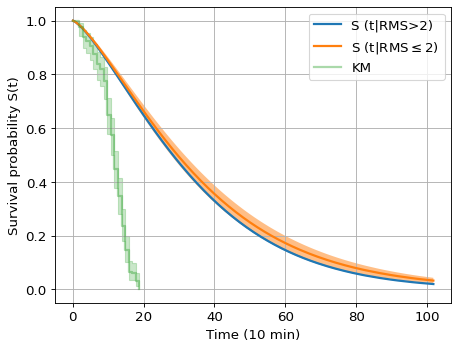

In [77]:
Resumer = Resume(data_X, data_X[["Survival_time", "Event"]], DATASET)

Km= KaplanMeierFitter()
Km.fit(durations= X_test_WB["Survival_time"], event_observed= X_test_WB["Survival_time"])
Km.predict(time_bins)

Resumer.plot_aggregate_sl (weibull_model, FEATURE_TO_SPLIT, time_bins, X_test_WB, survival, val_ref, Km)

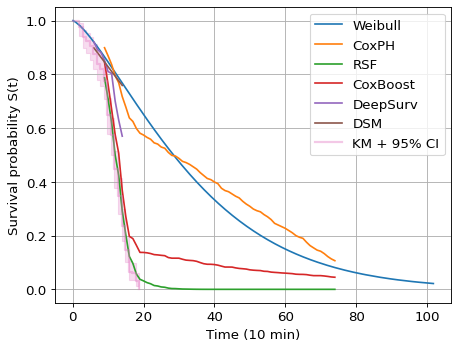

In [78]:
Resumer = Resume(data_X_test, data_y_test, DATASET)

surv_label= []
surv_label.append(weibull_surv_func)
surv_label.append(cph_surv_func)
surv_label.append(boost_surv_func)
surv_label.append(rsf_surv_func)
surv_label.append(NN_surv_func)
surv_label.append(DSM_surv_func)
   
Resumer.plot_aggregate_sl_mean (Km, surv_label)

## Supervised

In [14]:
model = cph_model
split_column = FEATURE_TO_SPLIT
time_bins = time_bins
survival_inst = survival
points = val_ref

surv_label= []
surv_label.append('S (t|RMS>2)')
surv_label.append('S (t|RMS$\leq$2)')

for point in points:
    plt.rcParams.update({'font.size': 12})
    plt.figure(dpi=80)
    X_test_g1 = X_test.loc[X_test[split_column] < point]
    X_test_g2 = X_test.loc[X_test[split_column] >= point]

    g1_index = X_test.loc[X_test['rms'] < 2].index
    g2_index = X_test.loc[X_test['rms'] >= 2].index

    y_test_g1 = y_test[g1_index]
    y_test_g2 = y_test[g2_index]

    y_test_event_time_g1U = y_test_g1[y_test_g1["Event"] == True] ["Survival_time"] 
    y_test_event_time_g2U = y_test_g2[y_test_g2["Event"] == True] ["Survival_time"]

    y_test_event_time_g1C = y_test_g1[y_test_g1["Event"] == False] ["Survival_time"] 
    y_test_event_time_g2C = y_test_g2[y_test_g2["Event"] == False] ["Survival_time"]

    y_1 = stats.CensoredData(
    uncensored=y_test_event_time_g1U,
    right=y_test_event_time_g1C
    )
    y_2 = stats.CensoredData(
    uncensored=y_test_event_time_g2U,
    right=y_test_event_time_g2C
    )  

    lr_test = stats.logrank(x=y_1, y=y_2)
    print (lr_test)

    surv_probs1 = survival_inst.predict_survival_function(model, X_test_g1, time_bins)
    surv_probs2 = survival_inst.predict_survival_function(model, X_test_g2, time_bins)
    surv_probs1_mean = np.mean(surv_probs1, axis= 0)
    surv_probs2_mean = np.mean(surv_probs2, axis= 0)

    time_bins = surv_probs1.columns

    surv_probs1_ci = 1.96 * np.std(surv_probs1, axis=0) / np.sqrt(len(surv_probs1)) # 95% CI
    surv_probs2_ci = 1.96 * np.std(surv_probs2, axis=0) / np.sqrt(len(surv_probs2))# 95% CI

    surv_probs1_mean.T.plot(linewidth= 2)
    surv_probs2_mean.T.plot(linewidth= 2)

    plt.fill_between(time_bins, surv_probs1_mean-surv_probs1_ci, surv_probs1_mean+surv_probs1_ci, linewidth=1, alpha=0.5)
    plt.fill_between(time_bins, surv_probs2_mean-surv_probs2_ci, surv_probs2_mean+surv_probs2_ci, linewidth=1, alpha=0.5)
    
plt.xlabel("Time (10 min)")
plt.ylabel("Survival probability S(t)")
plt.legend(surv_label)
plt.grid()

LogRankResult(statistic=-4.200397509881506, pvalue=2.664467622563737e-05)


ValueError: Found array with 0 sample(s) (shape=(0, 12)) while a minimum of 1 is required by CoxPHSurvivalAnalysis.

<Figure size 512x384 with 0 Axes>

LogRankResult(statistic=-1.8516577814248012, pvalue=0.06407498010133446)


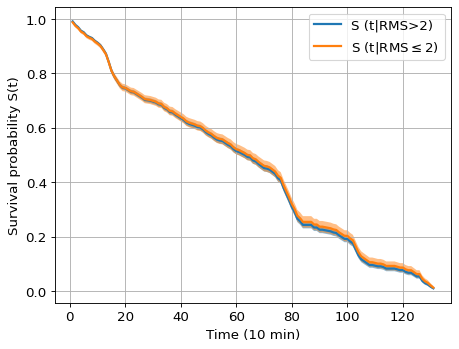

In [29]:
model = cph_model
split_column = FEATURE_TO_SPLIT
time_bins = time_bins
survival_inst = survival
points = val_ref

surv_label= []
surv_label.append('S (t|RMS>2)')
surv_label.append('S (t|RMS$\leq$2)')

for point in points:
    plt.rcParams.update({'font.size': 12})
    plt.figure(dpi=80)
    X_test_g1 = X_train
    X_test_g2 = X_test

    g1_index = X_train.index
    g2_index = X_test.index

    y_test_g1 = y_train[g1_index]
    y_test_g2 = y_test[g2_index]

    y_test_event_time_g1U = y_test_g1[y_test_g1["Event"] == True] ["Survival_time"] 
    y_test_event_time_g2U = y_test_g2[y_test_g2["Event"] == True] ["Survival_time"]

    y_test_event_time_g1C = y_test_g1[y_test_g1["Event"] == False] ["Survival_time"] 
    y_test_event_time_g2C = y_test_g2[y_test_g2["Event"] == False] ["Survival_time"]

    y_1 = stats.CensoredData(
    uncensored=y_test_event_time_g1U,
    right=y_test_event_time_g1C
    )
    y_2 = stats.CensoredData(
    uncensored=y_test_event_time_g2U,
    right=y_test_event_time_g2C
    )  

    lr_test = stats.logrank(x=y_1, y=y_2)
    #wilcoxon_test = stats.wilcoxon(x=X_train, y=X_test)
    print (lr_test)
    #print (wilcoxon_test)

    surv_probs1 = survival_inst.predict_survival_function(model, X_test_g1, time_bins)
    surv_probs2 = survival_inst.predict_survival_function(model, X_test_g2, time_bins)
    surv_probs1_mean = np.mean(surv_probs1, axis= 0)
    surv_probs2_mean = np.mean(surv_probs2, axis= 0)

    time_bins = surv_probs1.columns

    surv_probs1_ci = 1.96 * np.std(surv_probs1, axis=0) / np.sqrt(len(surv_probs1)) # 95% CI
    surv_probs2_ci = 1.96 * np.std(surv_probs2, axis=0) / np.sqrt(len(surv_probs2))# 95% CI

    surv_probs1_mean.T.plot(linewidth= 2)
    surv_probs2_mean.T.plot(linewidth= 2)

    plt.fill_between(time_bins, surv_probs1_mean-surv_probs1_ci, surv_probs1_mean+surv_probs1_ci, linewidth=1, alpha=0.5)
    plt.fill_between(time_bins, surv_probs2_mean-surv_probs2_ci, surv_probs2_mean+surv_probs2_ci, linewidth=1, alpha=0.5)
    
plt.xlabel("Time (10 min)")
plt.ylabel("Survival probability S(t)")
plt.legend(surv_label)
plt.grid()

In [18]:
def compute_survival_times(risk_scores, t_train, e_train, seed):
    # https://pubmed.ncbi.nlm.nih.gov/15724232/
    rnd = np.random.RandomState(seed)

    # generate survival time
    mean_survival_time = t_train[e_train].mean()
    baseline_hazard = 1. / mean_survival_time
    scale = baseline_hazard * np.exp(risk_scores)
    u = rnd.uniform(low=0, high=1, size=risk_scores.shape[0])
    t = -np.log(u) / scale

    return t, scale

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= TEST_SIZE, random_state = 0)

X_train = X_train.reset_index()

g1_index = X_train.loc[X_train['rms'] < 2].index
g2_index = X_train.loc[X_train['rms'] >= 2].index
y_train_g1 = y_train[g1_index]
y_train_g2 = y_train[g2_index]

In [19]:
risk_score_mean_g1 = cph_model.predict(X_test_g1)
risk_score_mean_g2 = cph_model.predict(X_test_g2)

surv_times1, scales1, surv_times2, scales2 = list(), list(), list(), list()
for i in range(0, 500):
    surv_time1, scale1 = compute_survival_times(risk_score_mean_g1, y_train_g1['Survival_time'], y_train_g1['Event'], i)
    surv_time2, scale2 = compute_survival_times(risk_score_mean_g2, y_train_g2['Survival_time'], y_train_g2['Event'], i)
    surv_times1.append(surv_time1[0])
    scales1.append(scale1[0])
    surv_times2.append(surv_time2[0])
    scales2.append(scale2[0])

Text(0.5, 0, 'Time (10 min)')

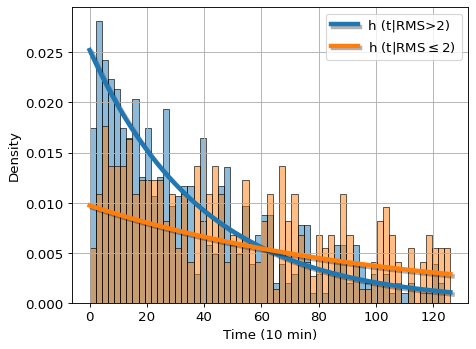

In [20]:
import seaborn as sns
import matplotlib.patheffects as path_effects


surv_label= []
surv_label.append('h (t|RMS>2)')
surv_label.append('h (t|RMS$\leq$2)')

plt.rcParams.update({'font.size': 12})

plt.figure(dpi=80)
hist_bins = np.linspace(0, 126, 60)
sns.histplot(surv_times1, bins=hist_bins, label="Surv times", alpha=0.5, stat="density")
sns.histplot(surv_times2, bins=hist_bins, label="Surv times", alpha=0.5, stat="density")
y1 = scale1[0] * np.exp(-scale1[0]*hist_bins)
y2 = scale2[0] * np.exp(-scale2[0]*hist_bins)
plt.plot(hist_bins, y1, linewidth=4, path_effects=[path_effects.SimpleLineShadow(), path_effects.Normal()])
plt.plot(hist_bins, y2, linewidth=4, path_effects=[path_effects.SimpleLineShadow(), path_effects.Normal()])
plt.legend(surv_label)
plt.grid()
plt.xlabel("Time (10 min)")

## Cutpoints with features (Stratification)

In [12]:
def transform_column_with_cutpoints(dataset, cut_points, column_name):
    new_df = dataset.copy()
    for cut_point in cut_points:
        new_column_name = f"{column_name}_<=_{cut_point}"
        new_df[new_column_name] = dataset[column_name] >= cut_point
    
    return new_df

# Example usage
data = {
    'age': [25, 30, 40, 22, 35, 42, 28, 50, 60],
    'income': [50000, 60000, 75000, 40000, 65000, 80000, 55000, 90000, 95000]
}

df = pd.DataFrame(data)

cut_points = [30, 40, 50]
column_to_transform = 'age'

transformed_df = transform_column_with_cutpoints(df, cut_points, column_to_transform)
print(transformed_df)

   age  income  age_<=_30  age_<=_40  age_<=_50
0   25   50000      False      False      False
1   30   60000       True      False      False
2   40   75000       True       True      False
3   22   40000      False      False      False
4   35   65000       True      False      False
5   42   80000       True       True      False
6   28   55000      False      False      False
7   50   90000       True       True       True
8   60   95000       True       True       True


## Unsupervised 

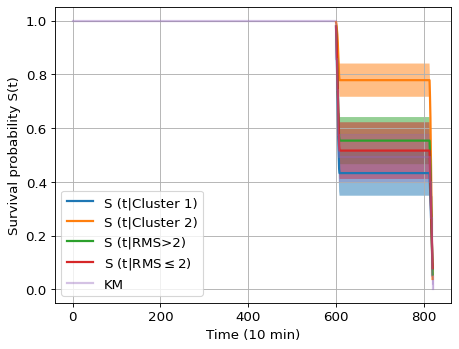

In [39]:
import umap
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

model = cph_model
split_column = FEATURE_TO_SPLIT
time_bins = time_bins
survival_inst = survival
points = val_ref

reducer = umap.UMAP(n_neighbors= 6,
                    min_dist= 0.8,
                    metric="manhattan")
embedding = reducer.fit_transform(X_test)

# pca = PCA(n_components=2)
# embedding = pca.fit_transform(X_test)

# Cluster the lower-dimensional representation using Agglomerative Clustering
num_clusters = 2
agglomerative = AgglomerativeClustering(n_clusters=num_clusters)
labels = agglomerative.fit_predict(embedding)

# Add the cluster labels back to the DataFrame
X_test['cluster'] = labels

# # Visualize the clusters
# plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='viridis')
# plt.colorbar()
# plt.show()

# # Print the cluster assignments
# print(df)

surv_label= []
surv_label.append('S (t|Cluster 1)')
surv_label.append('S (t|Cluster 2)')
surv_label.append('S (t|RMS>2)')
surv_label.append('S (t|RMS$\leq$2)')
#surv_label.append('P(S(t)|CLUSTER 3)')

plt.rcParams.update({'font.size': 12})
plt.figure(dpi=80)

for point in points:
    X_test_g1 = X_test.loc[X_test['cluster'] == 0]
    X_test_g2 = X_test.loc[X_test['cluster'] == 1]
#    X_test_g3 = X_test.loc[X_test['cluster'] == 2]

    X_test_g1 = X_test_g1.drop('cluster', axis=1)
    X_test_g2 = X_test_g2.drop('cluster', axis=1)
#    X_test_g3 = X_test_g3.drop('cluster', axis=1)           

    surv_probs1 = survival_inst.predict_survival_function(model, X_test_g1, time_bins)
    surv_probs2 = survival_inst.predict_survival_function(model, X_test_g2, time_bins)
#    surv_probs3 = survival_inst.predict_survival_function(model, X_test_g3, time_bins)
    surv_probs1_mean = np.mean(surv_probs1, axis= 0)
    surv_probs2_mean = np.mean(surv_probs2, axis= 0)
#    surv_probs3_mean = np.mean(surv_probs3, axis= 0)

    time_bins = surv_probs1.columns

    surv_probs1_ci = 1.96 * np.std(surv_probs1, axis=0) / np.sqrt(len(surv_probs1)) # 95% CI
    surv_probs2_ci = 1.96 * np.std(surv_probs2, axis=0) / np.sqrt(len(surv_probs2))# 95% CI
#    surv_probs3_ci = 1.96 * np.std(surv_probs3, axis=0) / np.sqrt(len(surv_probs3))# 95% CI

    surv_probs1_mean.T.plot(linewidth= 2, label= 'S (t|Cluster 1)')
    surv_probs2_mean.T.plot(linewidth= 2, label= 'S (t|Cluster 2)')
#    surv_probs3_mean.T.plot(linewidth= 2)

    plt.fill_between(time_bins, surv_probs1_mean-surv_probs1_ci, surv_probs1_mean+surv_probs1_ci, linewidth=1, alpha=0.5,)
    plt.fill_between(time_bins, surv_probs2_mean-surv_probs2_ci, surv_probs2_mean+surv_probs2_ci, linewidth=1, alpha=0.5)
#    plt.fill_between(time_bins, surv_probs3_mean-surv_probs3_ci, surv_probs3_mean+surv_probs3_ci, linewidth=1, alpha=0.5)

X_test = X_test.drop('cluster', axis=1)

for point in points:
    X_test_g1 = X_test.loc[X_test[split_column] < point]
    X_test_g2 = X_test.loc[X_test[split_column] >= point]

    surv_probs1 = survival_inst.predict_survival_function(model, X_test_g1, time_bins)
    surv_probs2 = survival_inst.predict_survival_function(model, X_test_g2, time_bins)
    surv_probs1_mean = np.mean(surv_probs1, axis= 0)
    surv_probs2_mean = np.mean(surv_probs2, axis= 0)

    time_bins = surv_probs1.columns

    surv_probs1_ci = 1.96 * np.std(surv_probs1, axis=0) / np.sqrt(len(surv_probs1)) # 95% CI
    surv_probs2_ci = 1.96 * np.std(surv_probs2, axis=0) / np.sqrt(len(surv_probs2))# 95% CI

    surv_probs1_mean.T.plot(linewidth= 2, label= 'S (t|RMS>2)')
    surv_probs2_mean.T.plot(linewidth= 2, label= 'S (t|RMS$\leq$2)')

    plt.fill_between(time_bins, surv_probs1_mean-surv_probs1_ci, surv_probs1_mean+surv_probs1_ci, linewidth=1, alpha=0.5)
    plt.fill_between(time_bins, surv_probs2_mean-surv_probs2_ci, surv_probs2_mean+surv_probs2_ci, linewidth=1, alpha=0.5)

Km.plot(linewidth=2, alpha=0.4, label= 'KM')
    
plt.xlabel("Time (10 min)")
plt.ylabel("Survival probability S(t)")
plt.legend()
# plt.legend(surv_label)
plt.grid()

## -Ln (-Ln) plot

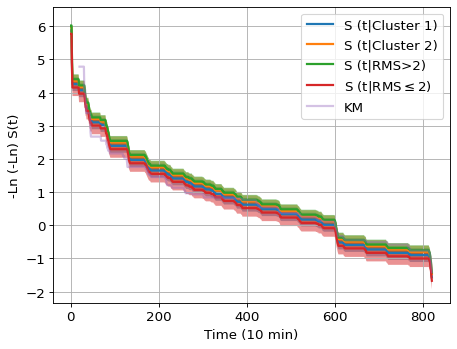

In [93]:
import umap
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

model = cph_model
split_column = FEATURE_TO_SPLIT
time_bins = time_bins
survival_inst = survival
points = val_ref

reducer = umap.UMAP(n_neighbors= 6,
                    min_dist= 0.8,
                    metric="manhattan")
embedding = reducer.fit_transform(X_test)

# pca = PCA(n_components=2)
# embedding = pca.fit_transform(X_test)

# Cluster the lower-dimensional representation using Agglomerative Clustering
num_clusters = 2
agglomerative = AgglomerativeClustering(n_clusters=num_clusters)
labels = agglomerative.fit_predict(embedding)

# Add the cluster labels back to the DataFrame
X_test['cluster'] = labels

# # Visualize the clusters
# plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='viridis')
# plt.colorbar()
# plt.show()

# # Print the cluster assignments
# print(df)

surv_label= []
surv_label.append('S (t|Cluster 1)')
surv_label.append('S (t|Cluster 2)')
surv_label.append('S (t|RMS>2)')
surv_label.append('S (t|RMS$\leq$2)')
#surv_label.append('P(S(t)|CLUSTER 3)')

plt.rcParams.update({'font.size': 12})
plt.figure(dpi=80)

for point in points:
    X_test_g1 = X_test.loc[X_test['cluster'] == 0]
    X_test_g2 = X_test.loc[X_test['cluster'] == 1]
#    X_test_g3 = X_test.loc[X_test['cluster'] == 2]

    X_test_g1 = X_test_g1.drop('cluster', axis=1)
    X_test_g2 = X_test_g2.drop('cluster', axis=1)
#    X_test_g3 = X_test_g3.drop('cluster', axis=1)           

    surv_probs1 = - np.log(- np.log(survival_inst.predict_survival_function(model, X_test_g1, time_bins)))
    surv_probs2 = - np.log(- np.log(survival_inst.predict_survival_function(model, X_test_g2, time_bins)))
#    surv_probs3 = survival_inst.predict_survival_function(model, X_test_g3, time_bins)
    surv_probs1_mean = np.mean(surv_probs1, axis= 0)
    surv_probs2_mean = np.mean(surv_probs2, axis= 0)
#    surv_probs3_mean = np.mean(surv_probs3, axis= 0)

    time_bins = surv_probs1.columns

    surv_probs1_ci = 1.96 * np.std(surv_probs1, axis=0) / np.sqrt(len(surv_probs1)) # 95% CI
    surv_probs2_ci = 1.96 * np.std(surv_probs2, axis=0) / np.sqrt(len(surv_probs2))# 95% CI
#    surv_probs3_ci = 1.96 * np.std(surv_probs3, axis=0) / np.sqrt(len(surv_probs3))# 95% CI

    surv_probs1_mean.T.plot(linewidth= 2, label= 'S (t|Cluster 1)')
    surv_probs2_mean.T.plot(linewidth= 2, label= 'S (t|Cluster 2)')
#    surv_probs3_mean.T.plot(linewidth= 2)

    plt.fill_between(time_bins, surv_probs1_mean-surv_probs1_ci, surv_probs1_mean+surv_probs1_ci, linewidth=1, alpha=0.5,)
    plt.fill_between(time_bins, surv_probs2_mean-surv_probs2_ci, surv_probs2_mean+surv_probs2_ci, linewidth=1, alpha=0.5)
#    plt.fill_between(time_bins, surv_probs3_mean-surv_probs3_ci, surv_probs3_mean+surv_probs3_ci, linewidth=1, alpha=0.5)

X_test = X_test.drop('cluster', axis=1)

for point in points:
    X_test_g1 = X_test.loc[X_test[split_column] < point]
    X_test_g2 = X_test.loc[X_test[split_column] >= point]

    surv_probs1 = - np.log(- np.log(survival_inst.predict_survival_function(model, X_test_g1, time_bins)))
    surv_probs2 = - np.log(- np.log(survival_inst.predict_survival_function(model, X_test_g2, time_bins)))
    surv_probs1_mean = np.mean(surv_probs1, axis= 0)
    surv_probs2_mean = np.mean(surv_probs2, axis= 0)

    time_bins = surv_probs1.columns

    surv_probs1_ci = 1.96 * np.std(surv_probs1, axis=0) / np.sqrt(len(surv_probs1)) # 95% CI
    surv_probs2_ci = 1.96 * np.std(surv_probs2, axis=0) / np.sqrt(len(surv_probs2))# 95% CI

    surv_probs1_mean.T.plot(linewidth= 2, label= 'S (t|RMS>2)')
    surv_probs2_mean.T.plot(linewidth= 2, label= 'S (t|RMS$\leq$2)')

    plt.fill_between(time_bins, surv_probs1_mean-surv_probs1_ci, surv_probs1_mean+surv_probs1_ci, linewidth=1, alpha=0.5)
    plt.fill_between(time_bins, surv_probs2_mean-surv_probs2_ci, surv_probs2_mean+surv_probs2_ci, linewidth=1, alpha=0.5)

Km_probs= - np.log(- np.log(Km.predict(time_bins)))
Km_probs.plot(linewidth=2, alpha=0.4, label= 'KM')
    
plt.xlabel("Time (10 min)")
plt.ylabel("-Ln (-Ln) S(t)")
plt.legend()
# plt.legend(surv_label)
plt.grid()

## RMST (Restricted Mean Survival Time)

<Axes: xlabel='timeline'>

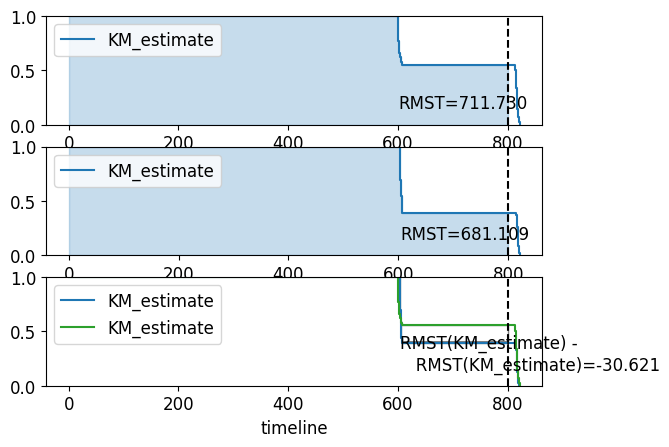

In [36]:
from matplotlib import pyplot as plt
from lifelines.plotting import rmst_plot

time_limit= 800

Km1= KaplanMeierFitter()
X_test_WB1 = X_test_WB.loc[X_test_WB[split_column] < point]
Km1.fit(durations= X_test_WB1["Survival_time"], event_observed= X_test_WB1["Survival_time"])

ax = plt.subplot(311)
rmst_plot(Km1 , t= time_limit, ax=ax)

Km2= KaplanMeierFitter()
X_test_WB2 = X_test_WB.loc[X_test_WB[split_column] >= point]
Km2.fit(durations= X_test_WB2["Survival_time"], event_observed= X_test_WB2["Survival_time"])

ax2 = plt.subplot(312)
rmst_plot(Km2, t= time_limit, ax=ax2)


ax3 = plt.subplot(313)
rmst_plot(Km2, model2=Km1, t= time_limit, ax=ax3)

<Axes: xlabel='timeline'>

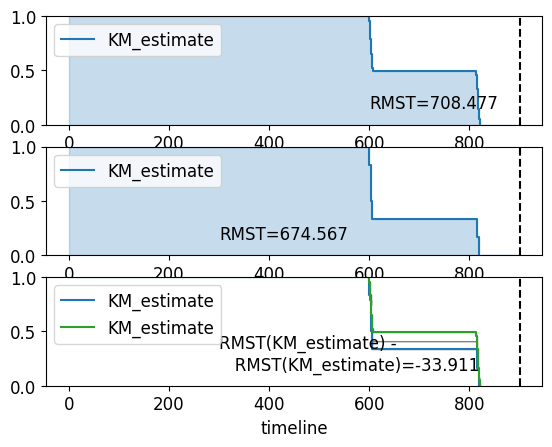

In [45]:
time_limit= 900

Km1= KaplanMeierFitter()
Km1.fit(durations= X_test_WB["Survival_time"], event_observed= X_test_WB["Survival_time"])

ax = plt.subplot(311)
rmst_plot(Km1 , t= time_limit, ax=ax)

Km2= KaplanMeierFitter()
Km2.fit(durations= X_test_WB2["Survival_time"], event_observed= X_test_WB2["Survival_time"])

ax2 = plt.subplot(312)
rmst_plot(Km2, t= time_limit, ax=ax2)


ax3 = plt.subplot(313)
rmst_plot(Km2, model2=Km1, t= time_limit, ax=ax3)

## Test PH assumption

In [256]:
cph = CoxPHFitter()#
X_spec= X.loc[:, ~X.columns.isin(['Fca','Fi','Fo','Fr','Frp','entropy', 'FrpH', 'FcaH'])]
cph.fit(X_spec, duration_col= "Survival_time", event_col= "Event")
cph.check_assumptions(X_spec, p_value_threshold=0.05, show_plots=False)
results = proportional_hazard_test(cph, X_spec, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

Proportional hazard assumption looks okay.


<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 50 total observations, 10 right-censored observations>
         test_name = proportional_hazard_test

---
           test_statistic    p  -log2(p)
FiH                  0.22 0.64      0.65
FoH                  0.02 0.88      0.19
FrH                  0.02 0.90      0.15
clearence            0.73 0.39      1.35
crest                0.07 0.80      0.33
impulse              0.09 0.76      0.39
kurtosis             0.37 0.54      0.88
max                  0.06 0.81      0.31
mean                 1.46 0.23      2.14
noise                0.00 0.98      0.03
p2p                  0.01 0.93      0.11
rms                  0.27 0.61      0.72
shape                0.07 0.78      0.35
skew                 0.03 0.85      0.23
std                  0.01 0.92      0.13

## Plotting

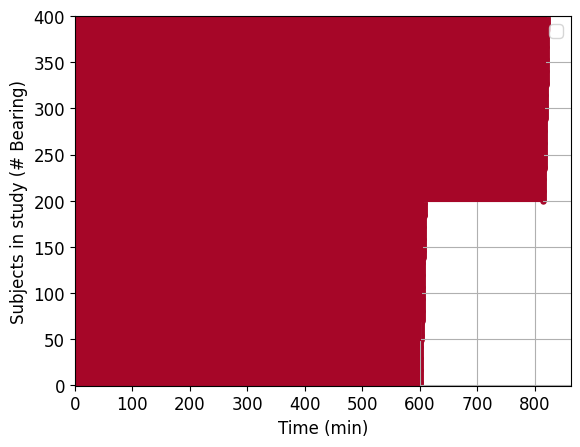

In [176]:
from lifelines.plotting import plot_interval_censored_lifetimes

ax = plot_interval_censored_lifetimes(X['Survival_time'], X['Survival_time'])
plt.xlabel("Time (min)")
plt.ylabel("Subjects in study (# Bearing)")
plt.legend()
# plt.legend(surv_label)
plt.grid()

There are 80 samples censored
20.0% of records are censored


<Figure size 900x600 with 0 Axes>

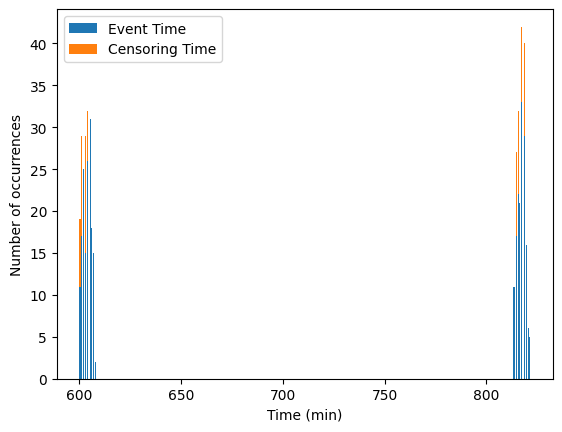

<Figure size 900x600 with 0 Axes>

In [6]:
n_censored = y.shape[0] - y["Event"].sum()
print ("There are {} samples censored".format(n_censored))
print("%.1f%% of records are censored" % (n_censored / y.shape[0] * 100))

val, bins, patches = plt.hist((y["Survival_time"][y["Event"]],
                                y["Survival_time"][~y["Event"]]),
                                bins=len(y), stacked=True)
_ = plt.legend(patches, ["Event Time", "Censoring Time"])
plt.xlabel("Time (min)")
plt.ylabel("Number of occurrences")
plt.figure(figsize=(9, 6))

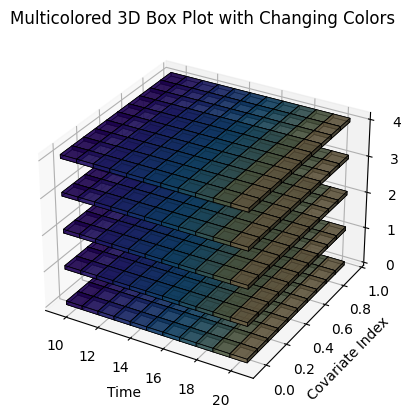

In [36]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Create data
x = np.arange(10, 21, 1)  # Time from 10 to 20
y = np.arange(0, 5, 1)    # 5 Covariates
z = np.arange(0, 1, 0.1)  # Covariate value

# Create grid of points for the 3D plot
X, Z, Y = np.meshgrid(x, y, z)  # Switch Y and Z axes

# Flatten the grids
x_flat = X.flatten()
y_flat = Y.flatten()
z_flat = Z.flatten()

# Create colors based on both time and covariate value
time_colors = plt.cm.viridis(np.linspace(0, 1, len(x)))
covariate_colors = plt.cm.plasma(np.linspace(0, 1, len(y)))

# Create figure and 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot each small cube with changing colors for each covariate type and time
for i in range(len(x_flat)):
    time_index = int(x_flat[i]) - 10
    covariate_index = int(y_flat[i])
    color = np.mean([time_colors[time_index], covariate_colors[covariate_index]], axis=0)
    
    ax.bar3d(x_flat[i] - 0.5, y_flat[i] - 0.05, z_flat[i], 1, 0.1, 0.1, shade=True, color=color, edgecolor='black', lw=0.5, alpha=0.7)

# Set labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Covariate Index')
ax.set_zlabel('Covariate Value')
ax.set_title('Multicolored 3D Box Plot with Changing Colors')

plt.show()

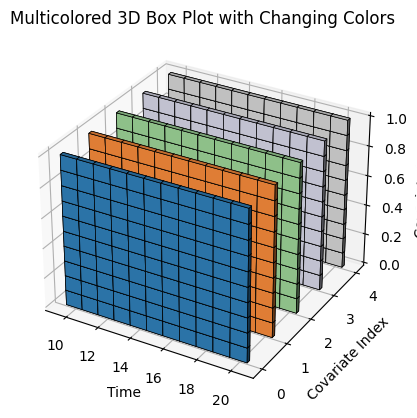

In [34]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Create data
x = np.arange(10, 21, 1)  # Time from 10 to 20
y = np.arange(0, 5, 1)    # 5 Covariates
z = np.arange(0, 1, 0.1)  # Covariate value

# Create grid of points for the 3D plot
X, Y, Z = np.meshgrid(x, y, z)

# Flatten the grids
x_flat = X.flatten()
y_flat = Y.flatten()
z_flat = Z.flatten()

# Define base colors for each element in the y layer
base_colors = plt.cm.tab20c(np.linspace(0, 1, len(y)))

# Create figure and 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot each small cube with base colors for y and logarithmic transparency for time
for i in range(len(x_flat)):
    time_index = int(x_flat[i]) - 10
    covariate_index = int(y_flat[i])
    layer_index = int(z_flat[i] * 10)
    
    base_color = base_colors[covariate_index]
    time_alpha = 1 - np.log10(1 + time_index) / np.log10(1 + len(x))  # Adjust transparency using logarithmic scale
    
    final_color = np.append(base_color[:3], time_alpha)  # Combine RGB with alpha
    
    ax.bar3d(x_flat[i] - 0.5, y_flat[i] - 0.05, z_flat[i], 1, 0.1, 0.1, shade=True, color=final_color, edgecolor='black', lw=0.5, alpha=1)

# Set labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Covariate Index')
ax.set_zlabel('Covariate Value')
ax.set_title('Multicolored 3D Box Plot with Changing Colors')

plt.show()


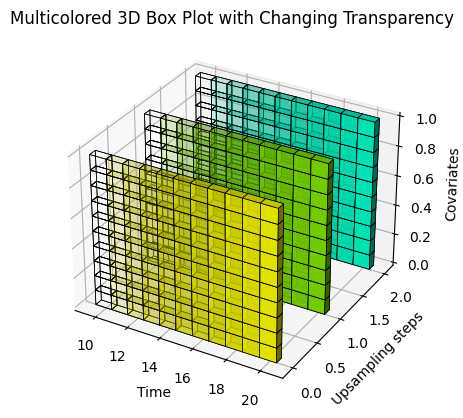

In [131]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Create data
x_start= 10
x_end= 20

x = np.arange(x_start, x_end + 1, 1)  # Time from 10 to 20
y = np.arange(0, 3, 1)    # 5 Covariates
z = np.arange(0, 1, 0.1)  # Covariate value

# Create grid of points for the 3D plot
X, Y, Z = np.meshgrid(x, y, z)

# Flatten the grids
x_flat = X.flatten()
y_flat = Y.flatten()
z_flat = Z.flatten()

# Define base colors for each element in the y layer
base_colors = [(1, 1, 0), (0.5, 0.9, 0), (0, 1, 0.8)]

# Create figure and 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot each small cube with base colors for y and adjusted transparency for time
for i in range(len(x_flat)):
    time_index = int(x_flat[i]) - x_start
    covariate_index = int(y_flat[i])
    layer_index = int(z_flat[i] * x_start)
    
    base_color = base_colors[covariate_index]
    time_alpha = (x_flat[i] - x_start) / (x_end - x_start)  # Adjust transparency based on x-axis
    
    ax.bar3d(x_flat[i] - 0.5, y_flat[i] - 0.05, z_flat[i], 1, 0.1, 0.1, shade=True, color=base_color[:3], edgecolor='black', lw=0.5, alpha= time_alpha)

# Set labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Upsampling steps')
ax.set_zlabel('Covariates')
ax.set_title('Multicolored 3D Box Plot with Changing Transparency')

plt.show()

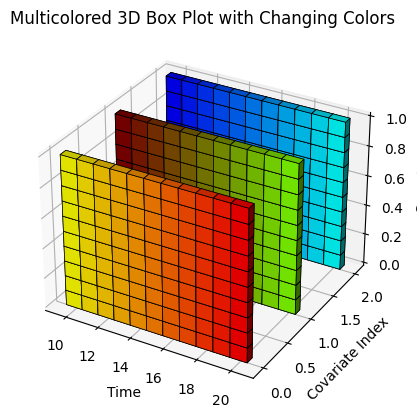

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Create data
x_start = 10
x_end = 20

x = np.arange(x_start, x_end + 1, 1)  # Time from 10 to 50
y = np.arange(0, 3, 1)    # 3 Covariates
z = np.arange(0, 1, 0.1)  # Covariate value

# Create grid of points for the 3D plot
X, Y, Z = np.meshgrid(x, y, z)

# Flatten the grids
x_flat = X.flatten()
y_flat = Y.flatten()
z_flat = Z.flatten()

# Define colors for each layer in y
layer_colors = [(1, 1, 0), (1, 0.5, 0), (0, 0, 1)]

# Create figure and 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot each small cube with fixed colors for y layers and changing transparency for time
for i in range(len(x_flat)):
    time_index = int(x_flat[i]) - x_start
    covariate_index = int(y_flat[i])
    layer_index = int(z_flat[i] * 10)
    
    base_color = layer_colors[covariate_index]
    time_alpha = (x_flat[i] - x_start) / (x_end - x_start)  # Adjust transparency based on x-axis
    
    if covariate_index == 0:
        r = base_color[0]
        g = base_color[1] - base_color[1] * time_alpha
        b = 0
    elif covariate_index == 1:
        r = base_color[1]
        g = 1 - (base_color[0] - base_color[0] * time_alpha)
        b = 0
    elif covariate_index == 2:
        r = 0
        g = base_color[1] + (1 - base_color[1]) * time_alpha
        b = base_color[2]
    
    final_color = (r, g, b)
    
    ax.bar3d(x_flat[i] - 0.5, y_flat[i] - 0.05, z_flat[i], 1, 0.1, 0.1, shade=True, color=final_color, edgecolor='black', lw=0.5, alpha=1)

# Set labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Covariate Index')
ax.set_zlabel('Samples')
ax.set_title('Multicolored 3D Box Plot with Changing Colors')

plt.show()


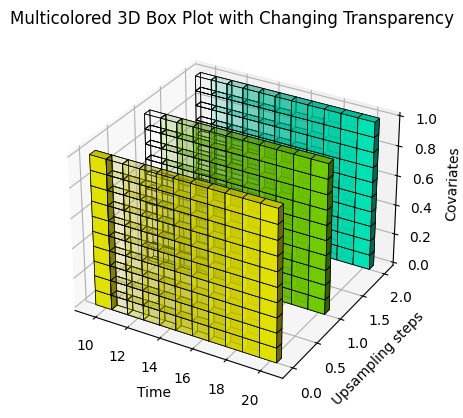

In [135]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Create data
x_start = 10
x_end = 20

x = np.arange(x_start, x_end + 1, 1)  # Time from 10 to 20
y = np.arange(0, 3, 1)    # 3 Covariates
z = np.arange(0, 1, 0.1)  # Covariate value

# Create grid of points for the 3D plot
X, Y, Z = np.meshgrid(x, y, z)

# Flatten the grids
x_flat = X.flatten()
y_flat = Y.flatten()
z_flat = Z.flatten()

# Define base colors for each element in the y layer
base_colors = [(1, 1, 0), (0.5, 0.9, 0), (0, 1, 0.8)]

# Create figure and 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot each small cube with base colors for y and adjusted transparency for time
for i in range(len(x_flat)):
    time_index = int(x_flat[i]) - x_start
    covariate_index = int(y_flat[i])
    layer_index = int(z_flat[i] * x_start)
    
    base_color = base_colors[covariate_index]
    time_alpha = (x_flat[i] - x_start) / (x_end - x_start)  # Adjust transparency based on x-axis
    
    # Adjust transparency for the first box in the first y layer
    if covariate_index == 0 and time_index == 0:
        alpha = 1
    else:
        alpha = time_alpha
    
    ax.bar3d(x_flat[i] - 0.5, y_flat[i] - 0.05, z_flat[i], 1, 0.1, 0.1, shade=True, color=base_color[:3], edgecolor='black', lw=0.5, alpha=alpha)

# Set labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Upsampling steps')
ax.set_zlabel('Covariates')
ax.set_title('Multicolored 3D Box Plot with Changing Transparency')

plt.show()


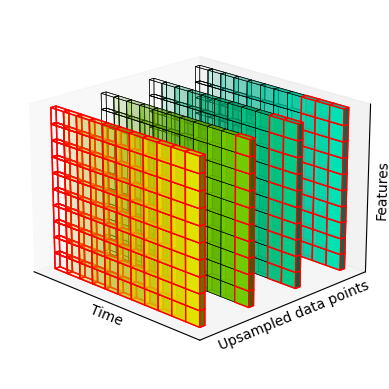

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Create data
x_start = 10
x_end = 20

x = np.arange(x_start, x_end + 1, 1)  # Time from 10 to 20
y = np.arange(0, 4, 1)    # 3 Covariates
z = np.arange(0, 1, 0.1)  # Covariate value

# Create grid of points for the 3D plot
X, Y, Z = np.meshgrid(x, y, z)

# Flatten the grids
x_flat = X.flatten()
y_flat = Y.flatten()
z_flat = Z.flatten()

# Define base colors for each element in the y layer
base_colors = [(1, 1, 0), (0.5, 0.9, 0), (0, 0.9, 0.6), (0, 1, 0.8)]

# Create figure and 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.view_init(elev=20, azim=-45)

# Plot each small cube with base colors for y and adjusted transparency for time
for i in range(len(x_flat)):
    time_index = int(x_flat[i]) - x_start
    covariate_index = int(y_flat[i])
    layer_index = int(z_flat[i] * x_start)
    
    base_color = base_colors[covariate_index]
    time_alpha = (x_flat[i] - x_start) / (x_end - x_start)  # Adjust transparency based on x-axis
    
    # Calculate transparency for each layer
    if covariate_index == 0:
        # if time_index == 0:
        #     alpha = 1 - (x_flat[i] - x_start) / (x_end - x_start)
        #     edge_color = 'red'
        #     line_width = 1
        # else:
        alpha = (x_flat[i] - x_start) / (x_end - x_start) 
        edge_color = 'red'
        line_width = 1
    elif covariate_index == 1:
        if time_index >=  10:
            alpha = (x_flat[i] - x_start) / (x_end - x_start) 
            edge_color = 'red'
            line_width = 1
        else:
            alpha = (x_flat[i] - x_start) / (x_end - x_start) 
            edge_color = 'black'
            line_width = 0.4
    elif covariate_index == 2:
        if time_index >= 9:
            alpha = (x_flat[i] - x_start) / (x_end - x_start) 
            edge_color = 'red'
            line_width = 1
        else:
            alpha = (x_flat[i] - x_start) / (x_end - x_start) 
            edge_color = 'black'
            line_width = 0.4
    elif covariate_index == 3:
        if time_index >= 8:
            alpha = (x_flat[i] - x_start) / (x_end - x_start) 
            edge_color = 'red'
            line_width = 1
        else:
            alpha = (x_flat[i] - x_start) / (x_end - x_start) 
            edge_color = 'black'
            line_width = 0.4
    
    ax.bar3d(x_flat[i] - 0.5, y_flat[i] - 0.05, z_flat[i], 1, 0.1, 0.1, shade=True, color=base_color[:3], edgecolor=edge_color, lw=line_width, alpha=alpha)

# Set labels and title

# Set axis labels
ax.set_xlabel('Time', rotation= -22, labelpad= -15)
ax.set_ylabel('Upsampled data points', labelpad= -15)
ax.set_zlabel('Features', rotation=90, labelpad= -15)

plt.show()


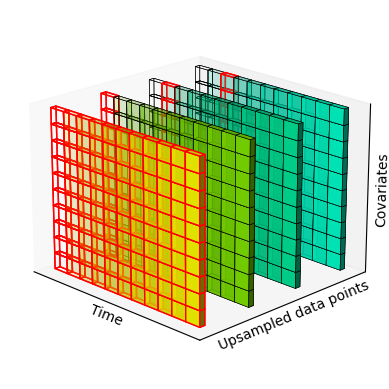

In [126]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Create data
x_start = 10
x_end = 20

x = np.arange(x_start, x_end + 1, 1)  # Time from 10 to 20
y = np.arange(0, 4, 1)    # 3 Covariates
z = np.arange(0, 1, 0.1)  # Covariate value

# Create grid of points for the 3D plot
X, Y, Z = np.meshgrid(x, y, z)

# Flatten the grids
x_flat = X.flatten()
y_flat = Y.flatten()
z_flat = Z.flatten()

# Define base colors for each element in the y layer
base_colors = [(1, 1, 0), (0.5, 0.9, 0), (0, 0.9, 0.6), (0, 1, 0.8)]

# Create figure and 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.view_init(elev=20, azim=-45)

# Plot each small cube with base colors for y and adjusted transparency for time
for i in range(len(x_flat)):
    time_index = int(x_flat[i]) - x_start
    covariate_index = int(y_flat[i])
    layer_index = int(z_flat[i] * x_start)
    
    base_color = base_colors[covariate_index]
    time_alpha = (x_flat[i] - x_start) / (x_end - x_start)  # Adjust transparency based on x-axis
    
    # Calculate transparency for each layer
    if covariate_index == 0:
        # if time_index == 0:
        #     alpha = 1 - (x_flat[i] - x_start) / (x_end - x_start)
        #     edge_color = 'red'
        #     line_width = 1
        # else:
        alpha = (x_flat[i] - x_start) / (x_end - x_start) 
        edge_color = 'red'
        line_width = 1
    elif covariate_index == 1:
        if time_index == 0:
            alpha = (x_flat[i] - x_start) / (x_end - x_start) 
            edge_color = 'red'
            line_width = 1
        else:
            alpha = (x_flat[i] - x_start) / (x_end - x_start) 
            edge_color = 'black'
            line_width = 0.4
    elif covariate_index == 2:
        if time_index == 1:
            alpha = (x_flat[i] - x_start) / (x_end - x_start) 
            edge_color = 'red'
            line_width = 1
        else:
            alpha = (x_flat[i] - x_start) / (x_end - x_start) 
            edge_color = 'black'
            line_width = 0.4
    elif covariate_index == 3:
        if time_index == 2:
            alpha = (x_flat[i] - x_start) / (x_end - x_start) 
            edge_color = 'red'
            line_width = 1
        else:
            alpha = (x_flat[i] - x_start) / (x_end - x_start) 
            edge_color = 'black'
            line_width = 0.4
    
    ax.bar3d(x_flat[i] - 0.5, y_flat[i] - 0.05, z_flat[i], 1, 0.1, 0.1, shade=True, color=base_color[:3], edgecolor=edge_color, lw=line_width, alpha=alpha)

# Set labels and title

# Set axis labels
ax.set_xlabel('Time', rotation= -22, labelpad= -15)
ax.set_ylabel('Upsampled data points', labelpad= -15)
ax.set_zlabel('Covariates', rotation=90, labelpad= -15)

plt.show()

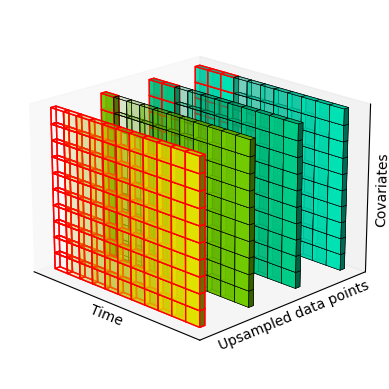

In [128]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Create data
x_start = 10
x_end = 20

x = np.arange(x_start, x_end + 1, 1)  # Time from 10 to 20
y = np.arange(0, 4, 1)    # 3 Covariates
z = np.arange(0, 1, 0.1)  # Covariate value

# Create grid of points for the 3D plot
X, Y, Z = np.meshgrid(x, y, z)

# Flatten the grids
x_flat = X.flatten()
y_flat = Y.flatten()
z_flat = Z.flatten()

# Define base colors for each element in the y layer
base_colors = [(1, 1, 0), (0.5, 0.9, 0), (0, 0.9, 0.6), (0, 1, 0.8)]

# Create figure and 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.view_init(elev=20, azim=-45)

# Plot each small cube with base colors for y and adjusted transparency for time
for i in range(len(x_flat)):
    time_index = int(x_flat[i]) - x_start
    covariate_index = int(y_flat[i])
    layer_index = int(z_flat[i] * x_start)
    
    base_color = base_colors[covariate_index]
    time_alpha = (x_flat[i] - x_start) / (x_end - x_start)  # Adjust transparency based on x-axis
    
    # Calculate transparency for each layer
    if covariate_index == 0:
        # if time_index == 0:
        #     alpha = 1 - (x_flat[i] - x_start) / (x_end - x_start)
        #     edge_color = 'red'
        #     line_width = 1
        # else:
        alpha = (x_flat[i] - x_start) / (x_end - x_start) 
        edge_color = 'red'
        line_width = 1
    elif covariate_index == 1:
        if time_index == 0:
            alpha = (x_flat[i - 140] - x_start) / (x_end - x_start)
            edge_color = 'red'
            line_width = 1
        else:
            alpha = (x_flat[i] - x_start) / (x_end - x_start) 
            edge_color = 'black'
            line_width = 0.4
    elif covariate_index == 2:
        if time_index <= 1:
            alpha = (x_flat[i - 140] - x_start) / (x_end - x_start)
            edge_color = 'red'
            line_width = 1
        else:
            alpha = (x_flat[i] - x_start) / (x_end - x_start) 
            edge_color = 'black'
            line_width = 0.4
    elif covariate_index == 3:
        if time_index <= 2:
            alpha = (x_flat[i - 140] - x_start) / (x_end - x_start)
            edge_color = 'red'
            line_width = 1
        else:
            alpha = (x_flat[i] - x_start) / (x_end - x_start) 
            edge_color = 'black'
            line_width = 0.4
    
    ax.bar3d(x_flat[i] - 0.5, y_flat[i] - 0.05, z_flat[i], 1, 0.1, 0.1, shade=True, color=base_color[:3], edgecolor=edge_color, lw=line_width, alpha=alpha)

# Set labels and title

# Set axis labels
ax.set_xlabel('Time', rotation= -22, labelpad= -15)
ax.set_ylabel('Upsampled data points', labelpad= -15)
ax.set_zlabel('Covariates', rotation=90, labelpad= -15)

plt.show()

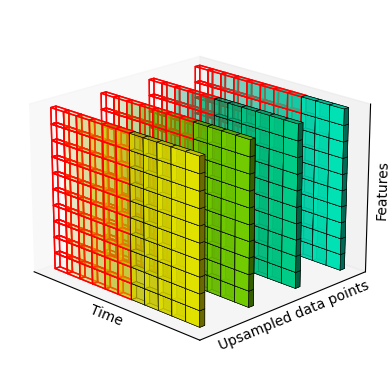

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Create data
x_start = 10
x_end = 20

x = np.arange(x_start, x_end + 1, 1)  # Time from 10 to 20
y = np.arange(0, 4, 1)    # 3 Covariates
z = np.arange(0, 1, 0.1)  # Covariate value

# Create grid of points for the 3D plot
X, Y, Z = np.meshgrid(x, y, z)

# Flatten the grids
x_flat = X.flatten()
y_flat = Y.flatten()
z_flat = Z.flatten()

# Define base colors for each element in the y layer
base_colors = [(1, 1, 0), (0.5, 0.9, 0), (0, 0.9, 0.6), (0, 1, 0.8)]

# Create figure and 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.view_init(elev=20, azim=-45)

# Plot each small cube with base colors for y and adjusted transparency for time
for i in range(len(x_flat)):
    time_index = int(x_flat[i]) - x_start
    covariate_index = int(y_flat[i])
    layer_index = int(z_flat[i] * x_start)
    
    base_color = base_colors[covariate_index]
    time_alpha = (x_flat[i] - x_start) / (x_end - x_start)  # Adjust transparency based on x-axis
    
    # Calculate transparency for each layer
    if covariate_index == 0:
        if time_index <= 5:
             alpha = (x_flat[i] - x_start) / (x_end - x_start)
             edge_color = 'red'
             line_width = 1
        else:
            alpha = (x_flat[i] - x_start) / (x_end - x_start) 
            edge_color = 'black'
            line_width = 0.4
    elif covariate_index == 1:
        if time_index <= 6:
            alpha = (x_flat[i] - x_start) / (x_end - x_start)
            edge_color = 'red'
            line_width = 1
        else:
            alpha = (x_flat[i] - x_start) / (x_end - x_start) 
            edge_color = 'black'
            line_width = 0.4
    elif covariate_index == 2:
        if time_index <= 4:
            alpha = (x_flat[i] - x_start) / (x_end - x_start)
            edge_color = 'red'
            line_width = 1
        else:
            alpha = (x_flat[i] - x_start) / (x_end - x_start) 
            edge_color = 'black'
            line_width = 0.4
    elif covariate_index == 3:
        if time_index <= 7:
            alpha = (x_flat[i] - x_start) / (x_end - x_start)
            edge_color = 'red'
            line_width = 1
        else:
            alpha = (x_flat[i] - x_start) / (x_end - x_start) 
            edge_color = 'black'
            line_width = 0.4
    
    ax.bar3d(x_flat[i] - 0.5, y_flat[i] - 0.05, z_flat[i], 1, 0.1, 0.1, shade=True, color=base_color[:3], edgecolor=edge_color, lw=line_width, alpha=alpha)

# Set labels and title

# Set axis labels
ax.set_xlabel('Time', rotation= -22, labelpad= -15)
ax.set_ylabel('Upsampled data points', labelpad= -15)
ax.set_zlabel('Features', rotation=90, labelpad= -15)

plt.show()

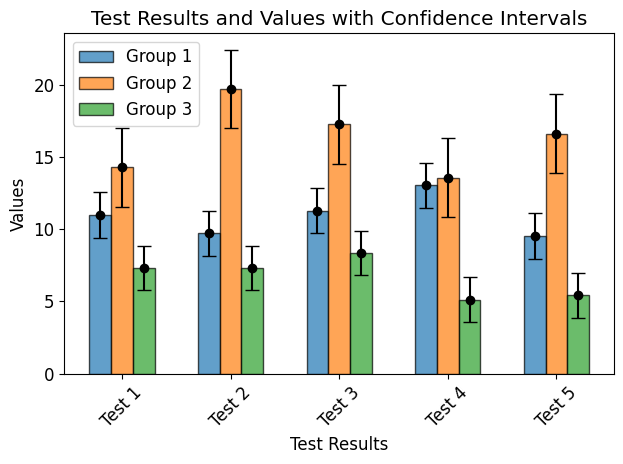

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Generate some sample test results and values for three groups
np.random.seed(42)
test_results = ['Test 1', 'Test 2', 'Test 3', 'Test 4', 'Test 5']
values_group1 = np.random.normal(10, 2, len(test_results))
values_group2 = np.random.normal(15, 3, len(test_results))
values_group3 = np.random.normal(8, 1.5, len(test_results))

# Combine all values for calculating overall statistics
all_values = np.concatenate((values_group1, values_group2, values_group3))

# Create the bar plot with different colors and black borders for each group
bar_width = 0.2
plt.bar(np.arange(len(test_results)) - bar_width, values_group1, width=bar_width, align='center', label='Group 1', alpha=0.7, edgecolor='black', linewidth=1)
plt.bar(np.arange(len(test_results)), values_group2, width=bar_width, align='center', label='Group 2', alpha=0.7, edgecolor='black', linewidth=1)
plt.bar(np.arange(len(test_results)) + bar_width, values_group3, width=bar_width, align='center', label='Group 3', alpha=0.7, edgecolor='black', linewidth=1)

# Calculate means and standard deviations for each group
mean_group1 = np.mean(values_group1)
std_group1 = np.std(values_group1)
mean_group2 = np.mean(values_group2)
std_group2 = np.std(values_group2)
mean_group3 = np.mean(values_group3)
std_group3 = np.std(values_group3)

# Calculate confidence intervals for each group
confidence_level = 0.95
n_per_group = len(test_results)
t_value = stats.t.ppf((1 + confidence_level) / 2, n_per_group - 1)
ci_group1 = t_value * (std_group1 / np.sqrt(n_per_group))
ci_group2 = t_value * (std_group2 / np.sqrt(n_per_group))
ci_group3 = t_value * (std_group3 / np.sqrt(n_per_group))

# Optionally add confidence intervals as error bars on top of each bar
show_confidence_intervals = True
if show_confidence_intervals:
    for i in range(len(test_results)):
        plt.errorbar(i - bar_width, values_group1[i], yerr=ci_group1, fmt='o', color='black', capsize=5)
        plt.errorbar(i, values_group2[i], yerr=ci_group2, fmt='o', color='black', capsize=5)
        plt.errorbar(i + bar_width, values_group3[i], yerr=ci_group3, fmt='o', color='black', capsize=5)

# Add labels and title
plt.xlabel('Test Results')
plt.ylabel('Values')
plt.title('Test Results and Values with Confidence Intervals')
plt.xticks(np.arange(len(test_results)), test_results, rotation=45)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


